##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\3.08"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

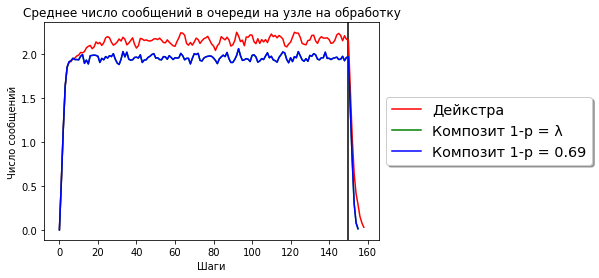

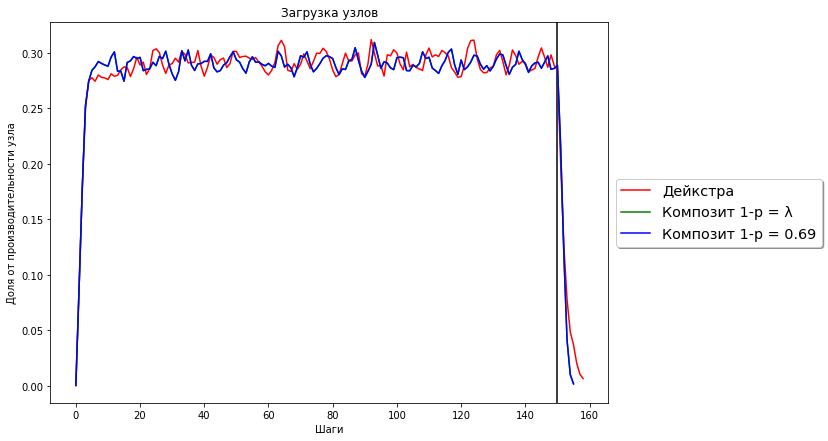

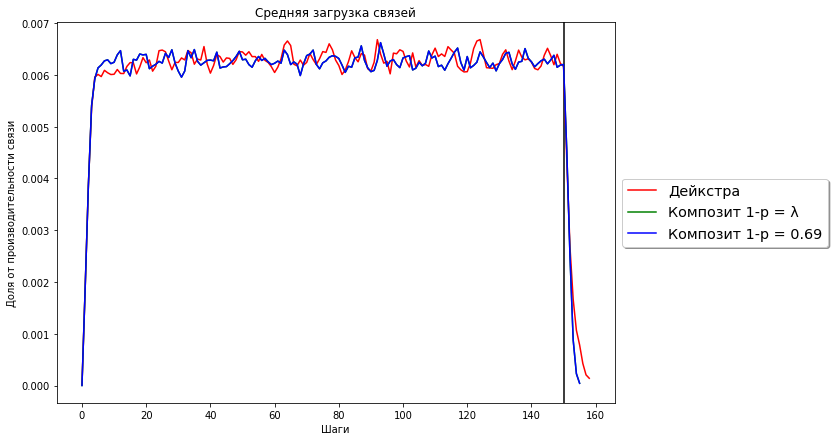

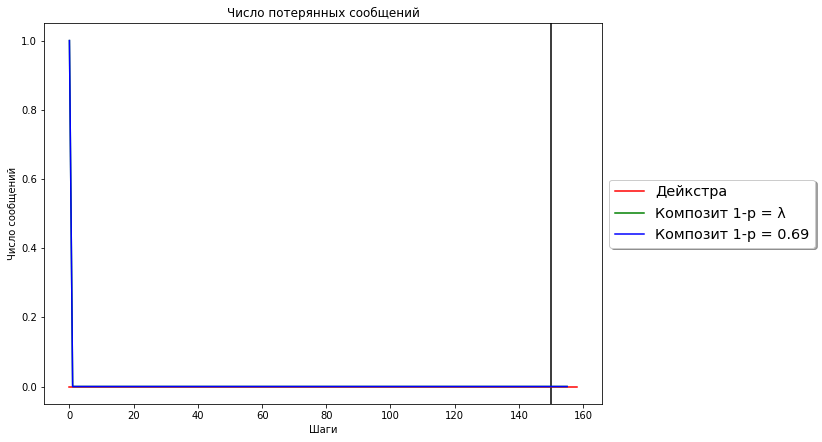

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.69


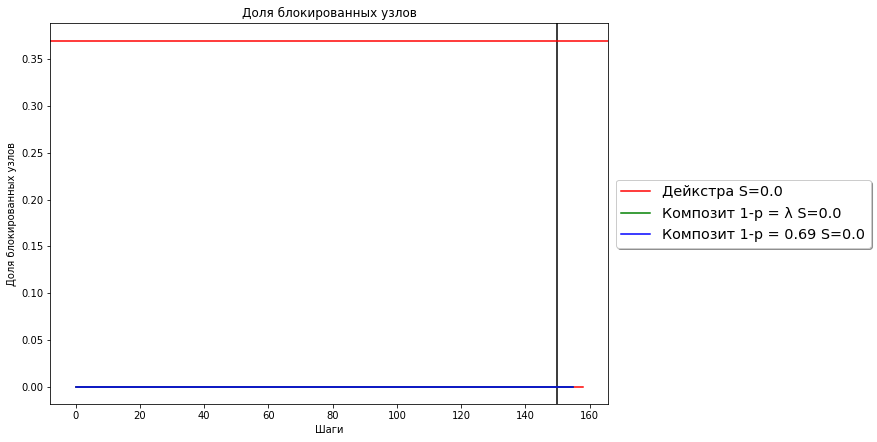

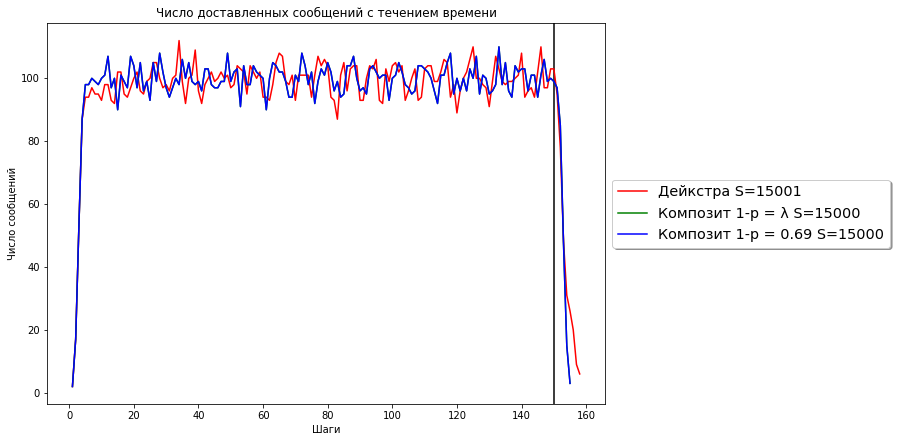

In [2]:
log_tags = [
 {"tag":  "9884fdb2-4d3c-4850-9b21-24adf3f61a6e", "label": "Дейкстра", "color": "red"},
# {"tag":  "2b650059-299c-4719-a35e-8e60331d0d22", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "50a65c0e-2dd8-4328-bd1f-0e16c7477c87", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "f7170ac0-49a2-4ebc-a2cf-d2e3417c9078", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
 
]
quantity = 100; 
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

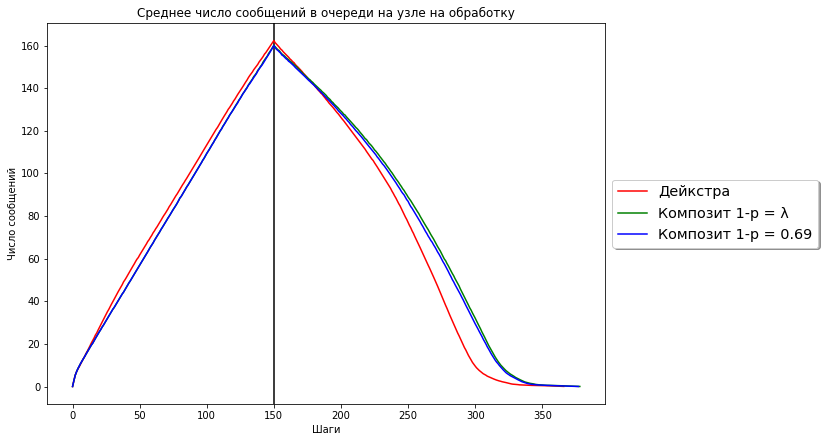

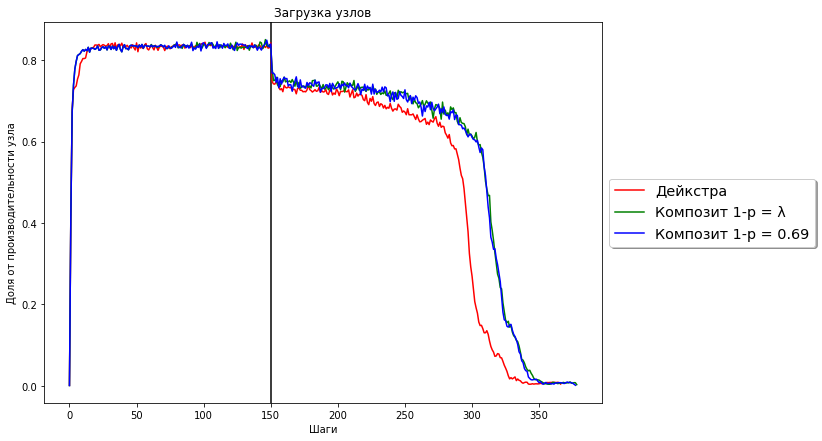

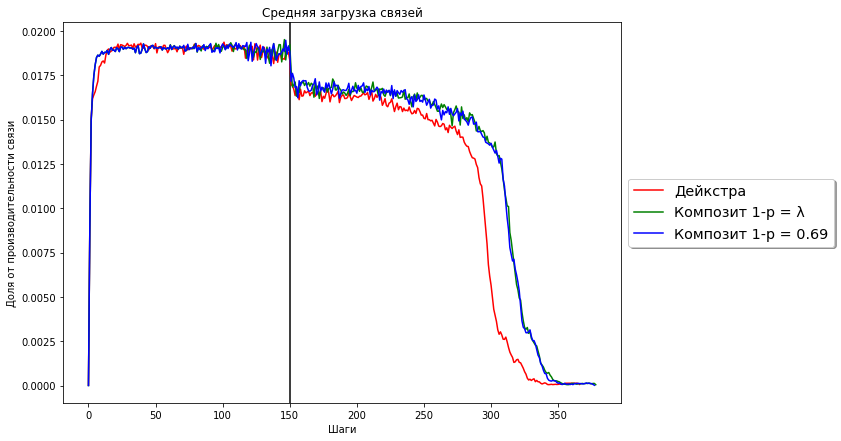

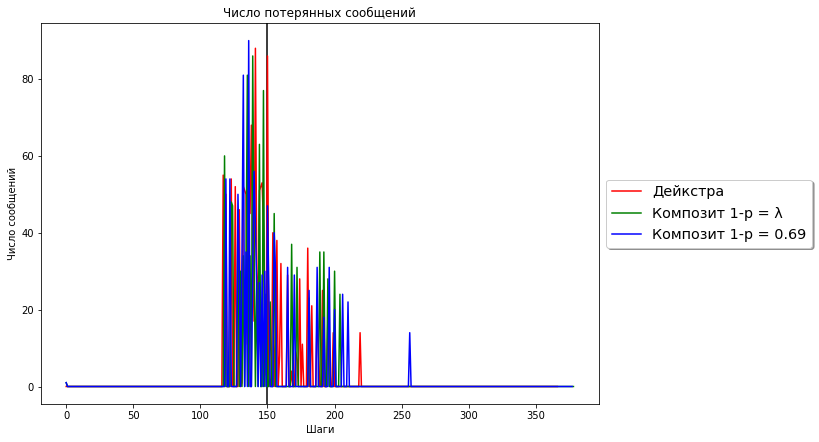

Доставлено 73530 Потеряно 1.9613% -Дейкстра
Доставлено 73968 Потеряно 1.3773% -Композит 1-p = λ
Доставлено 73944 Потеряно 1.4093% -Композит 1-p = 0.69


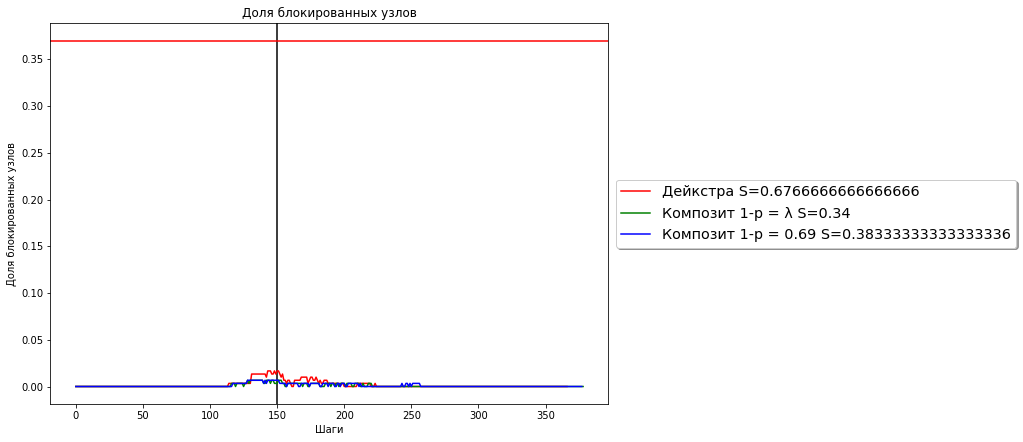

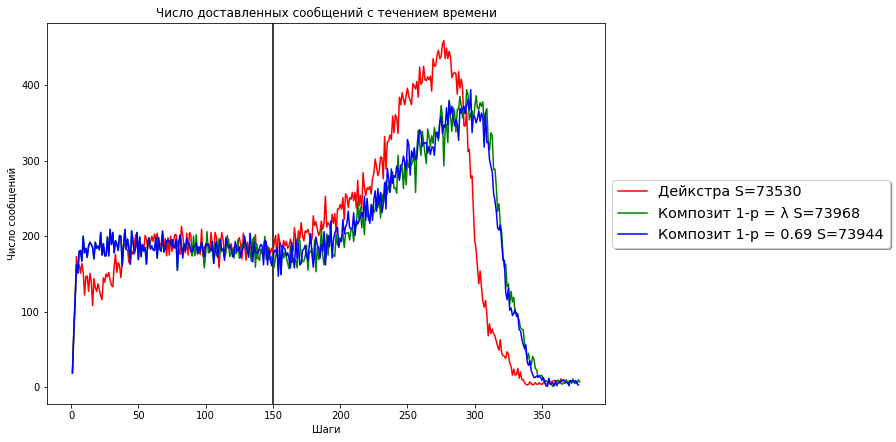

In [3]:
log_tags = [
 {"tag":  "bae753cd-497a-4bc4-a401-61e4abd04a95", "label": "Дейкстра", "color": "red"},
 #{"tag":  "07b446ae-f69e-436d-8eb0-5ef918e50bce", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "a4801dde-1ba1-4b93-95b8-23a65c9d3b6d", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "2c0dfa33-0fc8-442a-81c1-cf6d1f90659d", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

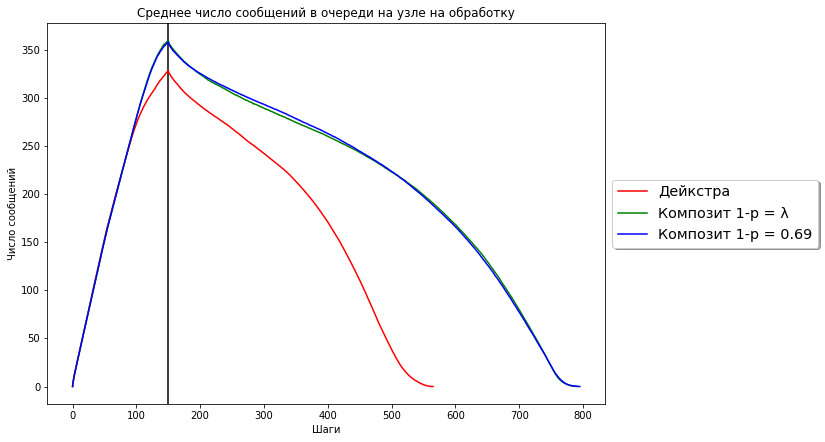

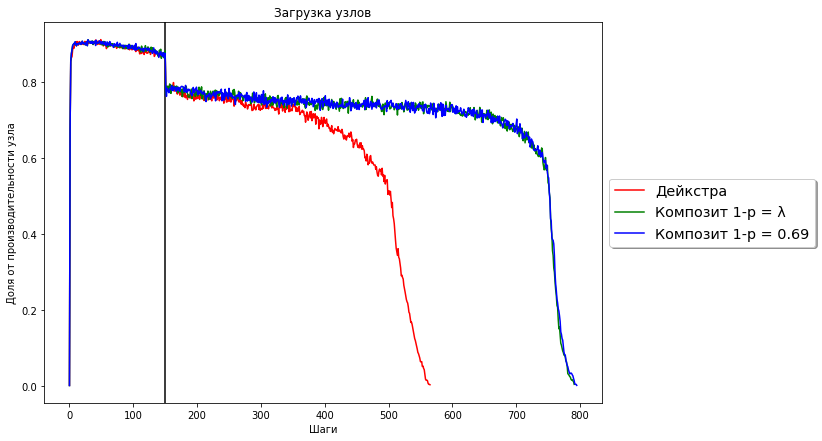

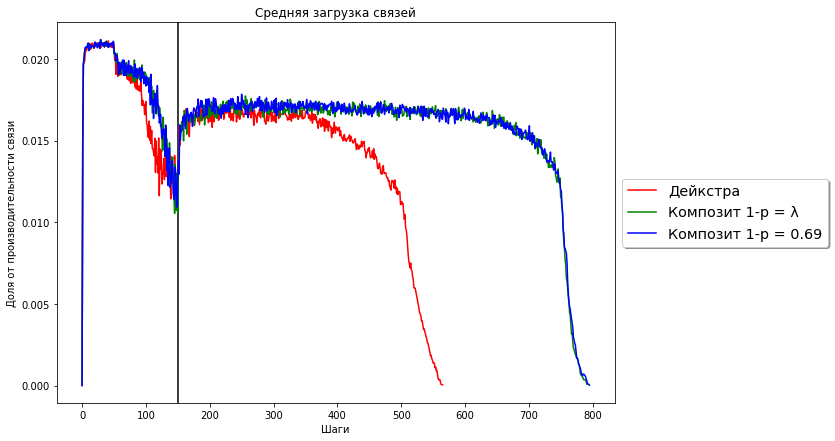

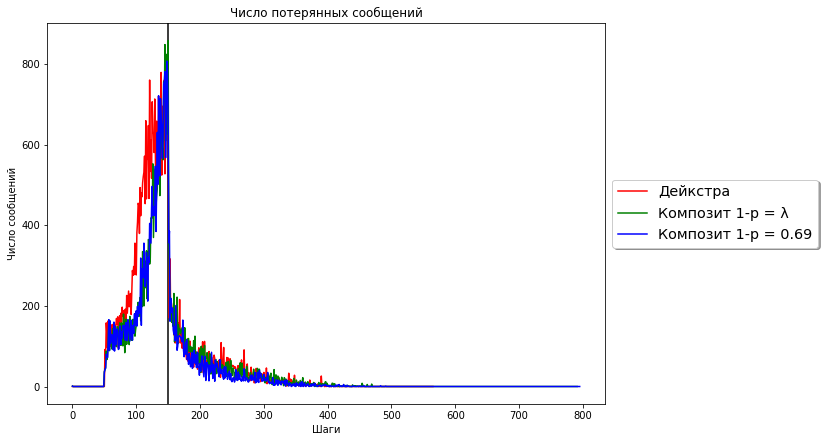

Доставлено 100454 Потеряно 33.0311% -Дейкстра
Доставлено 110030 Потеряно 26.6472% -Композит 1-p = λ
Доставлено 112017 Потеряно 25.3225% -Композит 1-p = 0.69


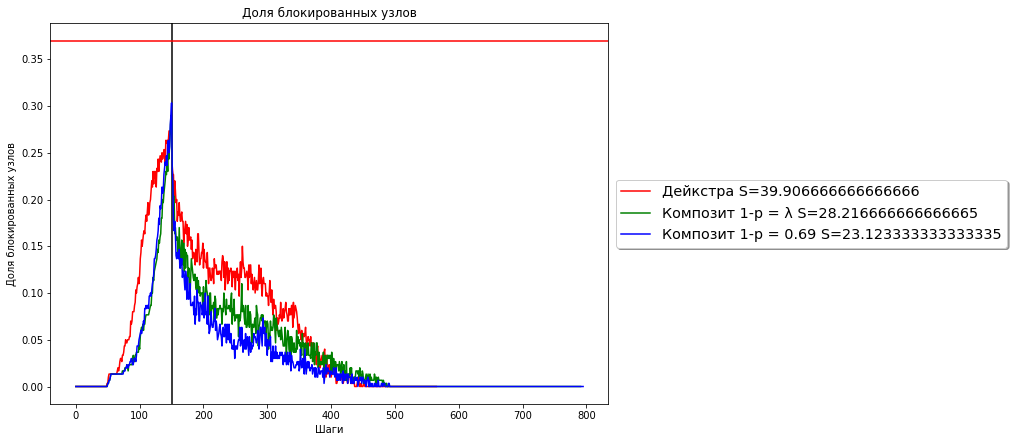

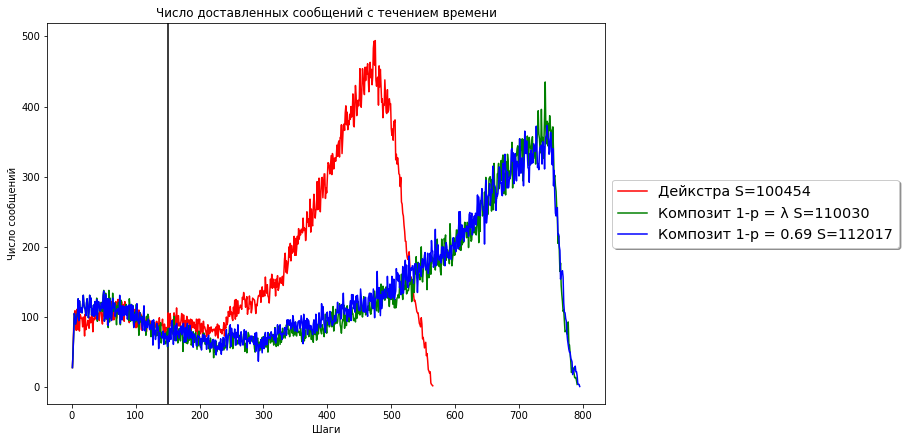

In [4]:
log_tags = [
 {"tag":  "c6b7f895-90ab-4ee9-a68f-ba7114acecaf", "label": "Дейкстра", "color": "red"},
 #{"tag":  "1155413f-6d21-499d-90b3-3e01b5de6bb3", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "2443b6b0-70c8-407c-a337-54868f81438d", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "815bd3f8-3223-43a6-8786-7126b4148139", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

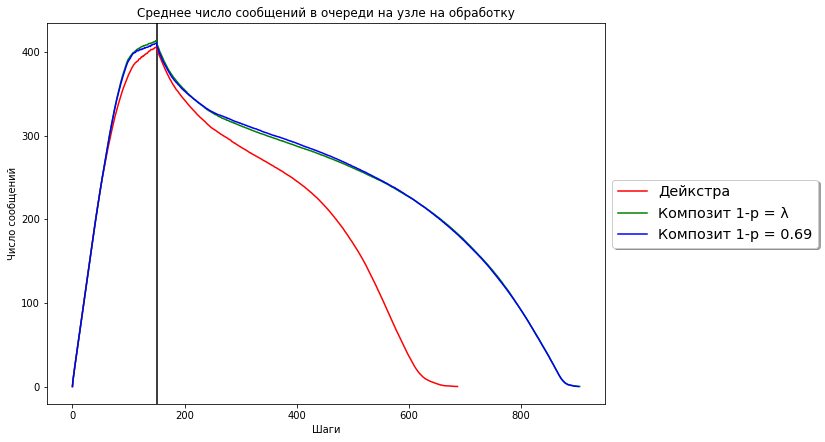

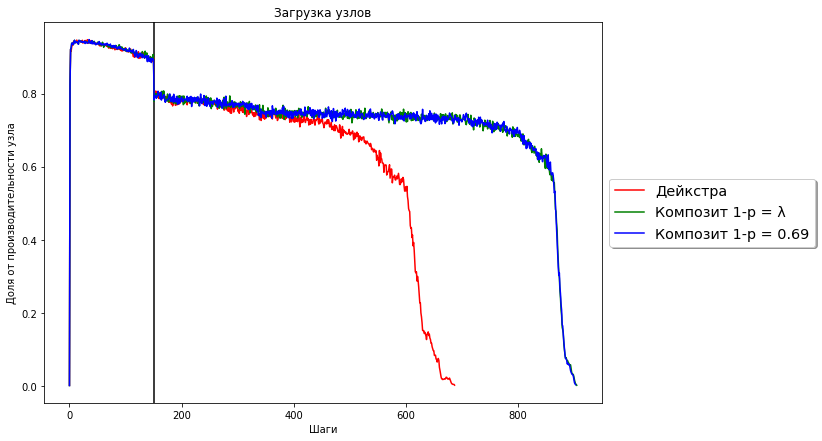

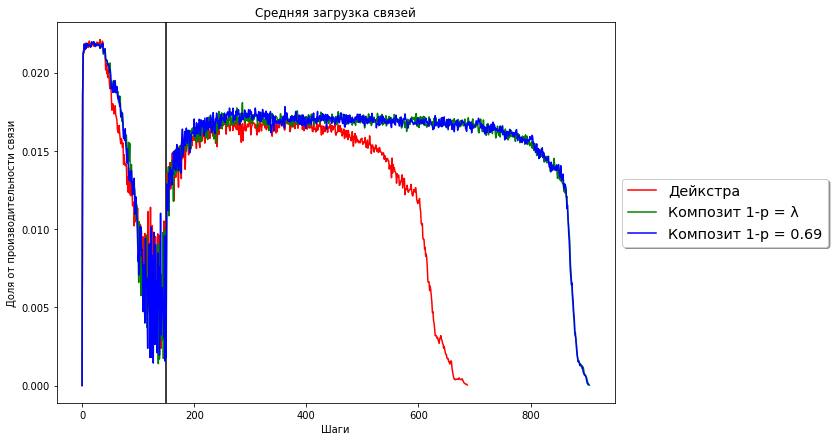

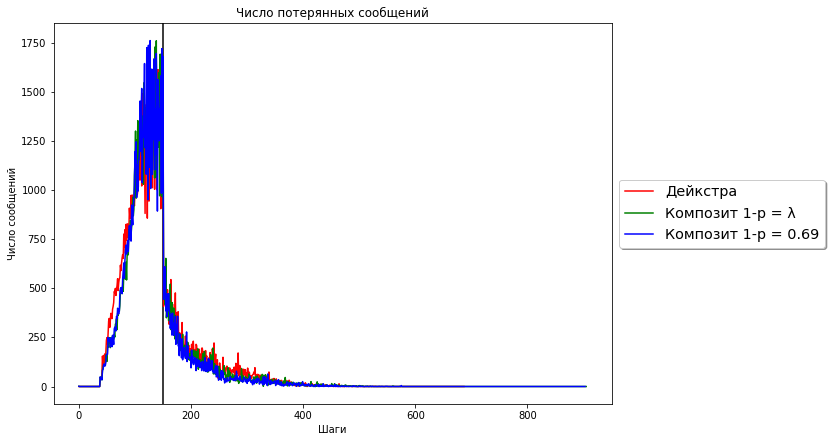

Доставлено 99149 Потеряно 55.9340% -Дейкстра
Доставлено 105884 Потеряно 52.9407% -Композит 1-p = λ
Доставлено 107666 Потеряно 52.1487% -Композит 1-p = 0.69


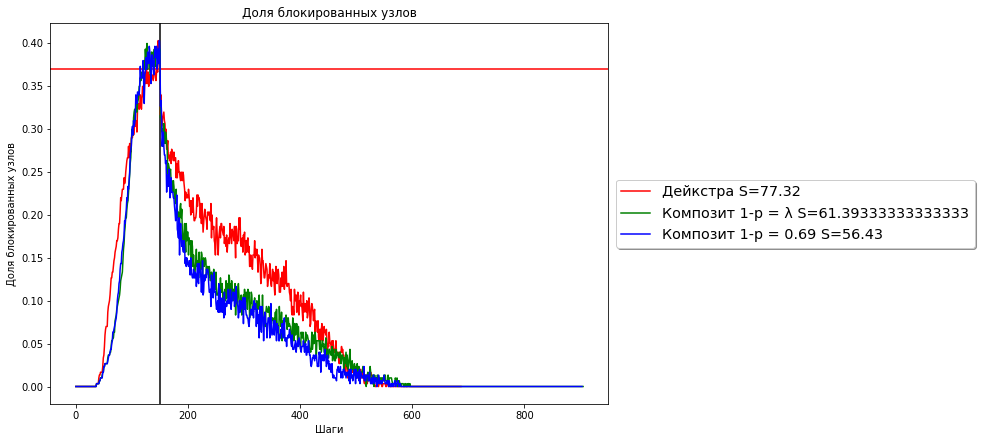

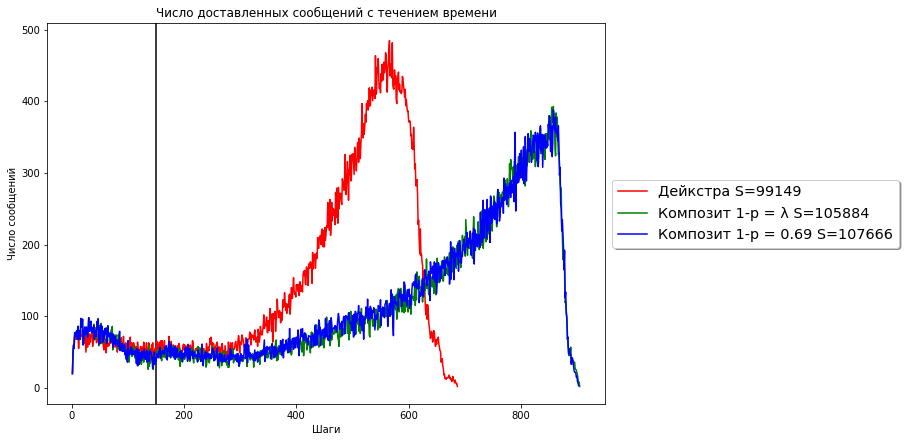

In [5]:
log_tags = [
 {"tag":  "945f28bd-02c4-4a7e-8405-931c12154586", "label": "Дейкстра", "color": "red"},
 #{"tag":  "4a376c54-9280-41b7-9d71-0bb8653f7014", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "086a41c1-6bfd-499f-b148-1dd71a79d8ca", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "29cfeb9e-2d99-40b3-bfad-a5dae2b180e3", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 45001 Потеряно 0.0000% -Дейкстра
Доставлено 44940 Потеряно 0.1356% -Композит 1-p = λ
Доставлено 44935 Потеряно 0.1467% -Композит 1-p = 0.69


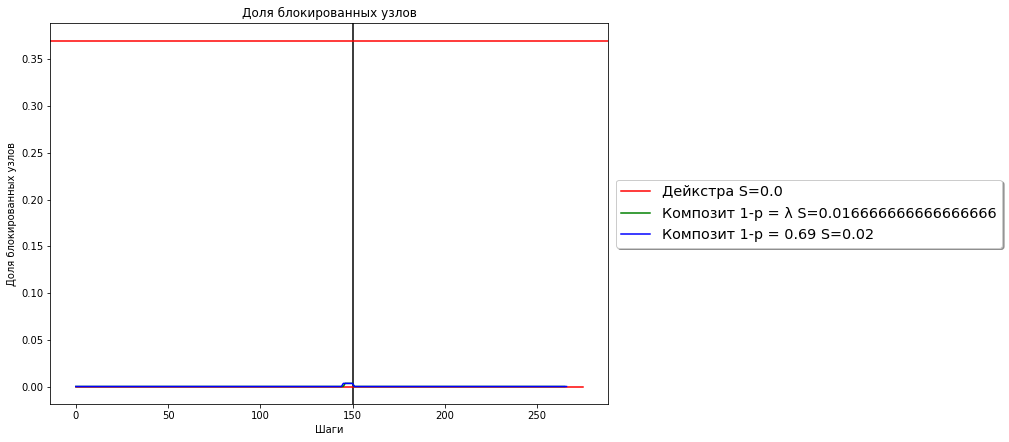

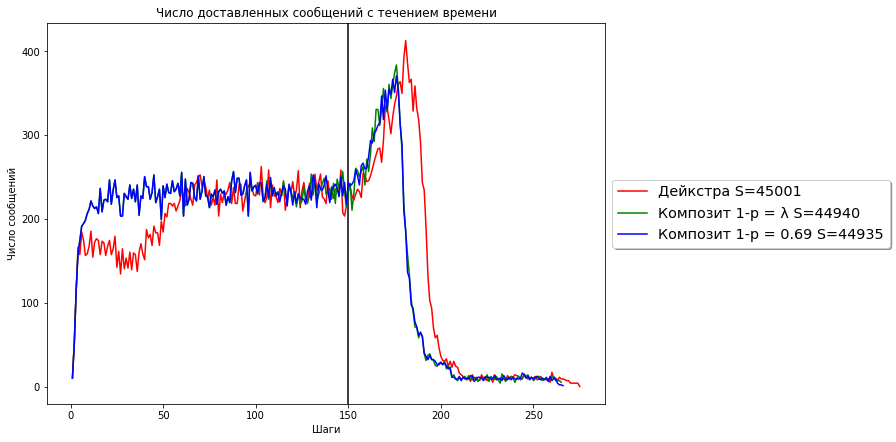

Доставлено 93181 Потеряно 11.2570% -Дейкстра
Доставлено 99538 Потеряно 5.2028% -Композит 1-p = λ
Доставлено 99683 Потеряно 5.0647% -Композит 1-p = 0.69


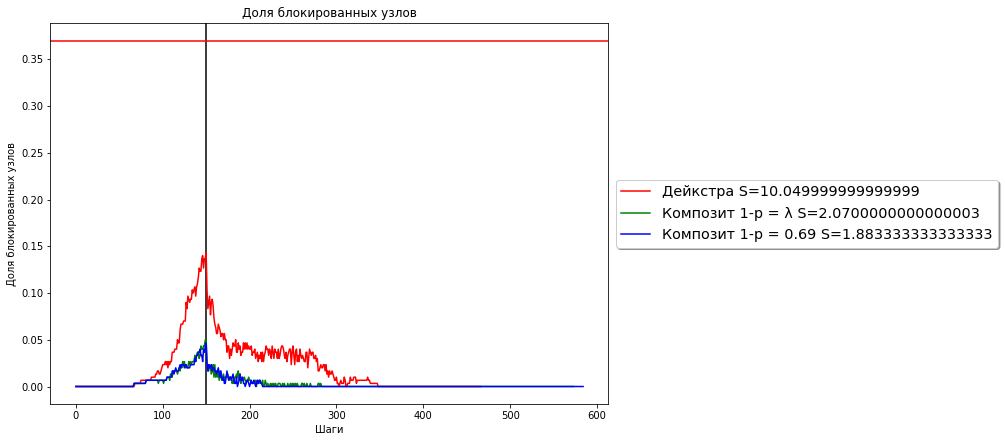

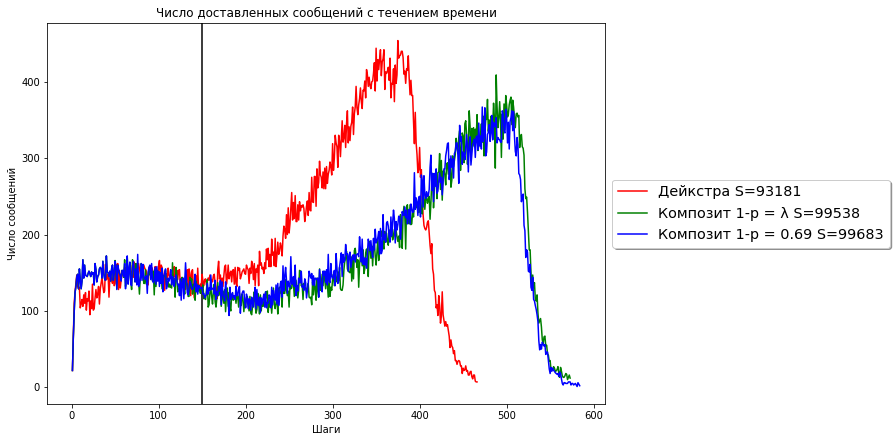

Доставлено 99144 Потеряно 26.5605% -Дейкстра
Доставлено 109610 Потеряно 18.8080% -Композит 1-p = λ
Доставлено 110574 Потеряно 18.0939% -Композит 1-p = 0.69


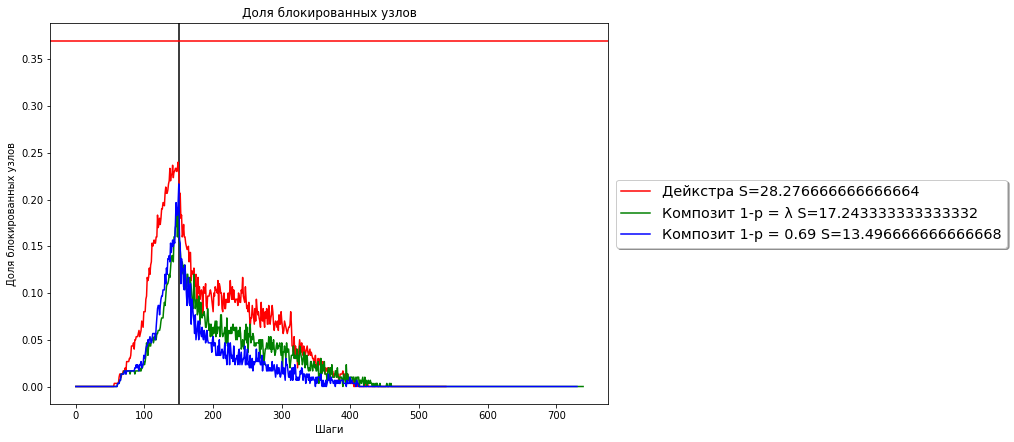

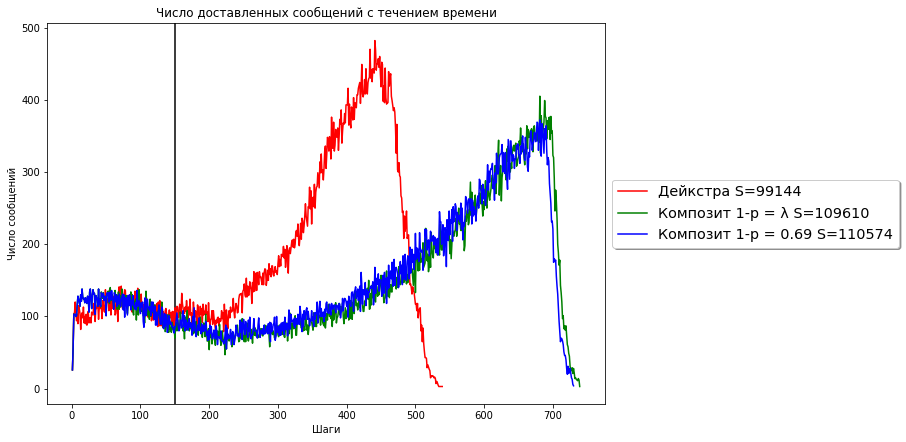

Доставлено 100627 Потеряно 48.3967% -Дейкстра
Доставлено 107513 Потеряно 44.8654% -Композит 1-p = λ
Доставлено 110321 Потеряно 43.4254% -Композит 1-p = 0.69


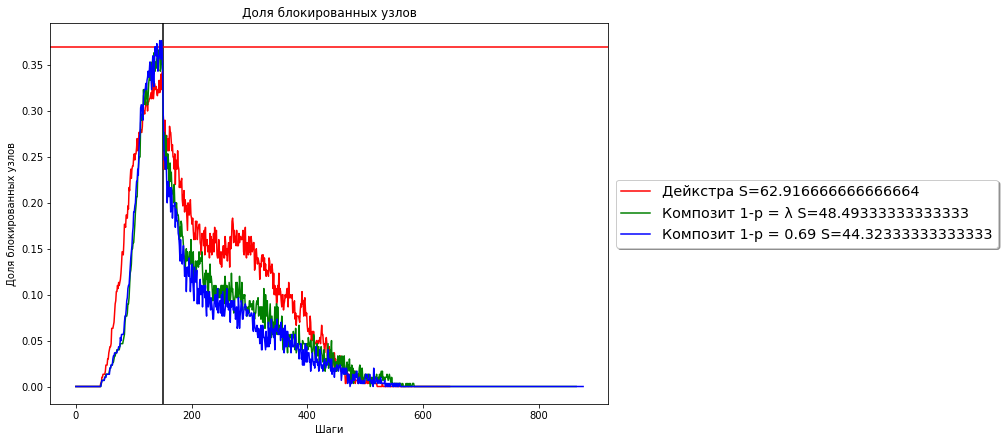

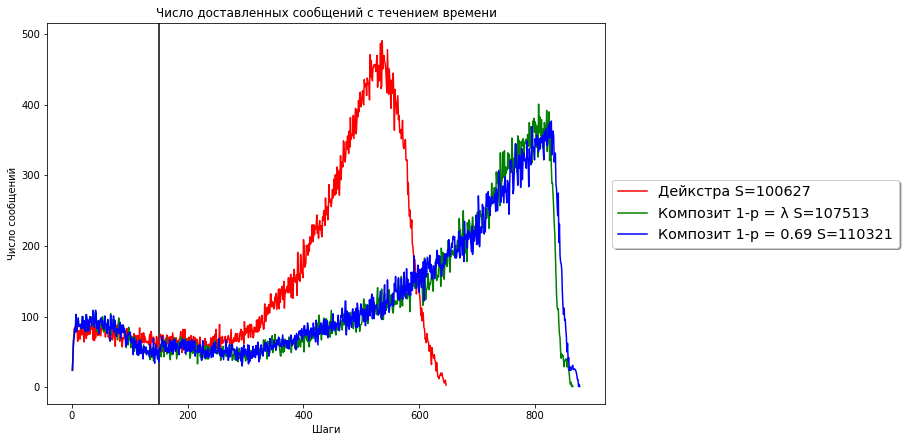

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "5e6eac3f-c501-4500-b5d7-799f263bfefc", "label": "Дейкстра", "color": "red"},
 {"tag":  "d5063ba0-f153-4ef2-b3cd-06b1f77a3273", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b6b4971b-ed3d-44ce-80e9-7770cadfd60b", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "673e7d7f-6a6e-47bc-a7ae-9832cf632343", "label": "Дейкстра", "color": "red"},
 {"tag":  "3bcf81d8-8039-4d8d-8af5-72b8068a48cf", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "3ebf8173-6e1b-4d8f-a858-7a75e79d5a89", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "b39034ff-b7d7-4bcc-bac4-b2712726976c", "label": "Дейкстра", "color": "red"},
 {"tag":  "33653022-21a8-4655-927f-fa0f6d5515c8", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "7929684c-362e-4013-a99d-2611305d1b9b", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "c0719ac3-5d07-49fa-ac0e-db96e3da7cfa", "label": "Дейкстра", "color": "red"},
 {"tag":  "9fa4c1d0-66ab-404b-95e4-bea74ecce5cf", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b10c548f-d813-4f4f-97c0-d547009524b7", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

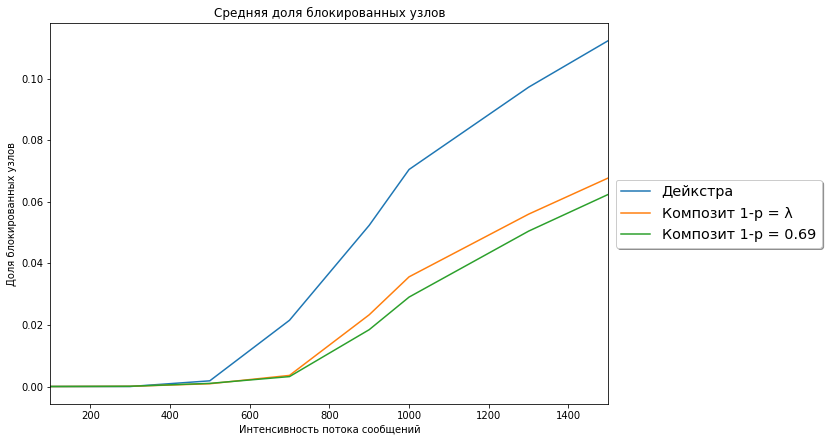

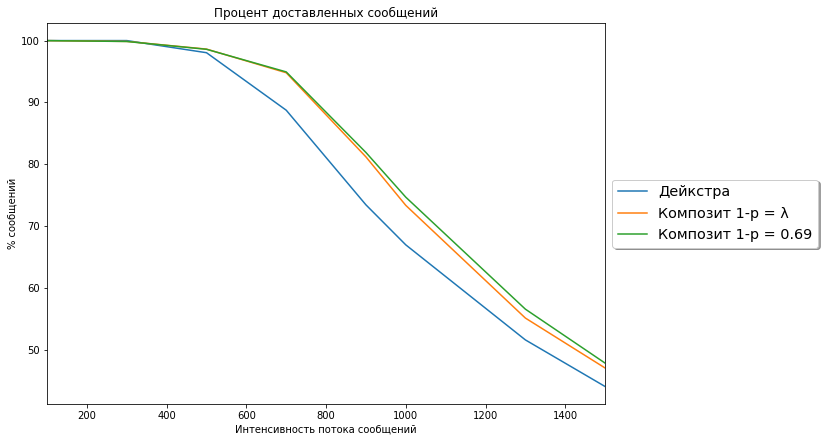

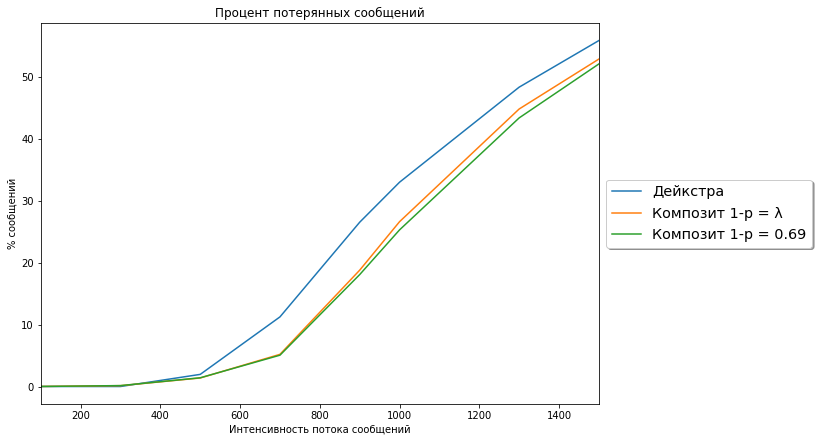

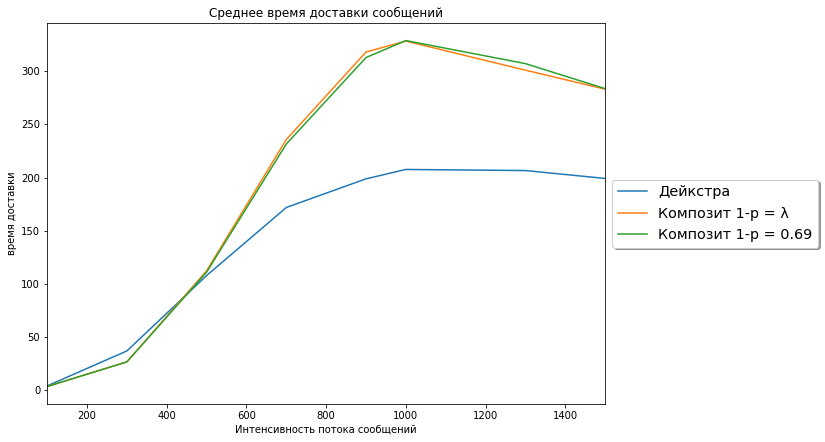

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.044483
Композит 1-p = λ       0.023407
Композит 1-p = 0.69    0.020591

Дейкстра               22.142581
Композит 1-p = λ       18.747946
Композит 1-p = 0.69    18.202234

Дейкстра               141.650172
Композит 1-p = λ       201.155933
Композит 1-p = 0.69    200.704512
